# Gating

A gate partitions the data space into two or more non-overlapping regions. Gates are typically defined on only one or two channels/dimensions when created manually, but many gate types are not technically restricted to this and may be of arbitrary dimension (especially when created by machine).

In `pycyt`, gates can be used to either filter rows of a table-like object (most commonly, but not necessarily, a `FlowFrame`) according to whether they belong to a specific region or to get an explicit sequence of region membership by row. You can also get simple membership counts and percentages. Most gate classes in `pycyt` inherit from `SimpleGate`, which has two regions "in" and "out" referring to an interior and exterior. Gating is done on the "in" region by default. `QuadGate` divides the data space into many regions, so one must always be specified (either on instantiation or on use).

Let's load in an FCS file to work with:

/home/jared/git/pycyt/pycyt/io/fcsfile.py:282: UserWarning: FCS version of "/home/jared/git/pycyt/pycyt/examples/data/CD133+CD38- population in human Early Preterm Cord Blood.fcs" is 3.0, may be incompatible
  .format(self._path, self._version[3:]))


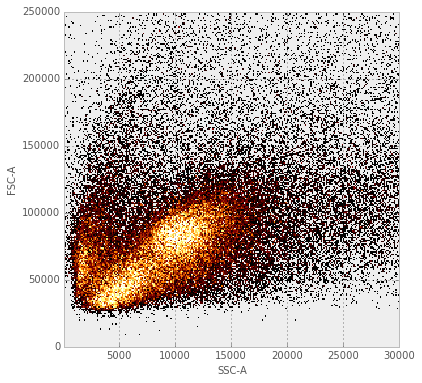

In [1]:
# pycyt and numpy imports
from pycyt import FlowFrame
from pycyt.gates import *
import numpy as np

# Show matplotlib plots in notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Load in an FCS file
from pkg_resources import resource_filename
filepath = resource_filename('pycyt.examples.data', r'CD133+CD38- population in human Early Preterm Cord Blood.fcs')
ff = FlowFrame(filepath)

# Plot it on SSC-A/FSC-A
from pycyt.plotting import density2d
ax = plt.figure(figsize=(6, 6)).add_subplot()
plt_range = [[1e2, 3e4], [0, 2.5e5]]
density2d(ff[['SSC-A', 'FSC-A']], range=plt_range, ax=ax)

The first step in an analysis might be to select the live cells by gating on `FSC`/`SSC`. Below we programmatically create a rough polygon gate and apply it to our `FlowFrame` to get another `FlowFrame` instance containing only the events that fall within the gate.

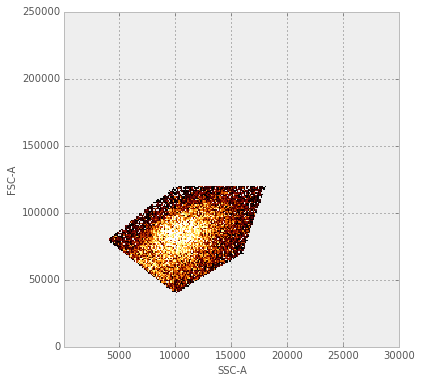

In [2]:
live_gate = PolyGate(['FSC-A', 'SSC-A'], [(8e4, 4e3), (12e4, 1e4), (12e4, 1.8e4), (7e4, 1.6e4), (4e4, 1e4)])
live_cells = live_gate(ff)

ax = plt.figure(figsize=(6, 6)).add_subplot()
density2d(live_cells[['SSC-A', 'FSC-A']], range=plt_range, ax=ax)

So what actually happened there? Well first we created a `PolyGate` instance on the `SSC-A` and `FSC-A` channels. All the non-composite gate types take a list of channels as the first argument to their constructor. The other argument was the vertices of the polygon as a list of coordinate pairs. Below we check the basic attributes that all gates have:

In [3]:
print 'Channels:', live_gate.channels
print 'Number of dimensions:', live_gate.ndim
print 'Regions in gate:', live_gate.regions
print 'Default region:', repr(live_gate.default_region)

Channels: ['FSC-A', 'SSC-A']
Number of dimensions: 2
Regions in gate: set(['out', 'in'])
Default region: 'in'


Note that gates in `pycyt` are immutable so you can't change any of these things. If you need to do that, use the `copy` method and pass in any constructor arguments you want to override.

To gate, it's as simple as calling our gate as a function on our `FlowFrame`. This returns another `FlowFrame` with all the same channels but only the events contained in the gate.

In [4]:
print ff.channels, ff.tot
print live_cells.channels, live_cells.tot

['FSC-A', 'SSC-A', 'FITC-A', 'PE-A', 'PerCP-A', 'PE-Cy7-A', 'APC-A', 'APC-Cy7-A', 'Time'] 100000
['FSC-A', 'SSC-A', 'FITC-A', 'PE-A', 'PerCP-A', 'PE-Cy7-A', 'APC-A', 'APC-Cy7-A', 'Time'] 29530


You can gate on other types of objects too. The argument can be any "table-like" object. This would be mostly `FlowFrame`s or maybe `pandas.DataFrame`s. In this case, column/channel names in the argument are automatically matched to the gate channels. A two-dimensional `numpy.ndarray` may also be used, in which case it is assumed the columns of the array match the channels of the gate exactly. A one-dimensional `numpy.ndarray` or a `pandas.Series` may also be used if the gate is one-dimensional. In any case, the returned value will be in the same format.

The second argument is the region of the gate to use. Many gate classes have a `default_region` that specifies the region to use if not explicitly given when the gate is called. Most gates inherit from `SimpleGate` so automatically use the "in" region as the default.

In [5]:
print 'Total events:', ff.tot
print '"in" region:', live_gate(ff).tot
print '"out" region:', live_gate(ff, region='out').tot

Total events: 100000
"in" region: 29530
"out" region: 70470


There are also a few other things you can do with gates. You can use the `contains` method to get a `numpy.ndarray` of boolean values telling you whether each event is in the region or not. It takes the same arguments as when filtering.

In [6]:
live_gate.contains(ff)

array([ True, False,  True, ..., False, False, False], dtype=bool)

Finally, you can get a simple count or fraction of the events inside the gate.

In [7]:
print 'Events inside:', live_gate.count(ff)
print 'Fraction of events inside:', live_gate.frac(ff)

Events inside: 29530
Fraction of events inside: 0.2953


## Gate Classes

Let's set up some test data and functions to display the different gate types below:

In [8]:
# Create points randomly distributed in a square
n = 25000
points = np.random.random((n, 2)) * 10

# Two fake channel names and a FlowFrame containing the points
channels = ['Channel1', 'Channel2']
frame = FlowFrame(points, channels=channels)

# Function that colors the points based on whether they're in the gate or not
plt.rcParams['figure.figsize'] = (14, 4)
def test_gate(gate, title=None, region=None):
    in_gate = gate.contains(frame, region=region)
    plt.scatter(frame['Channel1'], frame['Channel2'], c=np.where(in_gate, '#0000FF', '#9999FF'), s=2, lw=0)
    plt.xlabel(channels[0])
    plt.ylabel(channels[1])
    plt.xlim([-1, 11])
    plt.ylim([-1, 11])
    if title:
        plt.title(title)

## Rectangle Gates

Rectangle gates correspond to regions where the value of each channel is within some range, and are implemented by the `RectangleGate` class. They are defined by a channel list and a list of (min, max) tuples. In accordance with the Gating-ML standard ranges may be open on one end, which is specified by giving `None` as the minimum or maximum of a range. There may be an arbitrary number of channels.

Rect 1 ranges: [[3.0, 8.0], [1.0, 4.0]]


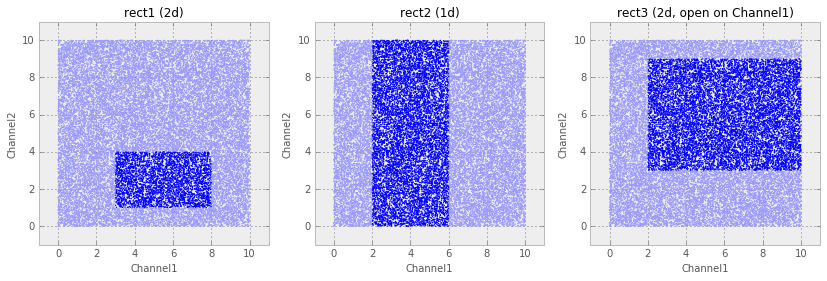

In [9]:
rect1 = RectangleGate(channels, [(3, 8), (1, 4)]) # Basic rectangle gate
rect2 = RectangleGate([channels[0]], [(2, 6)]) # 1-D gate on single channel (range gate)
rect3 = RectangleGate(channels, [(2, None), (3, 9)]) # Open range on first channel

print 'Rect 1 ranges:', rect1.ranges

plt.subplot(131)
test_gate(rect1, 'rect1 (2d)')

plt.subplot(132)
test_gate(rect2, 'rect2 (1d)')

plt.subplot(133)
test_gate(rect3, 'rect3 (2d, open on Channel1)')

## Polygon Gates

Polygon gates define a polygonal interior from two channels and an ordered list of vertex coordinates, and are implemented by the `PolyGate` class. As shown below polygons may be convex, non-convex, or even non-simple (with interior points determined by the even/odd winding number rule, as per the Gating-ML standard). Note that the gating algorithm for convex polygons is significantly faster than the algorithm for non-convex ones.

poly1 vertices: [array([5, 1]), array([1, 6]), array([3, 9]), array([8, 8]), array([10,  4])]
poly1 is convex
poly2 is not convex


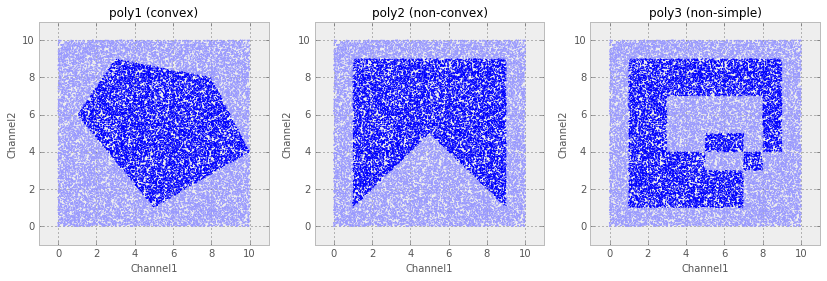

In [10]:
poly1 = PolyGate(channels, [(5, 1), (1, 6), (3, 9), (8, 8), (10, 4)])
poly2 = PolyGate(channels, [(1, 1), (1, 9), (9, 9), (9, 1), (5, 5)])
poly3 = PolyGate(channels, [(1, 1), (1, 9), (9, 9), (9, 4), (3, 4), (3, 7), (8, 7), (8, 3), (5, 3), (5, 5), (7, 5), (7, 1)])

print 'poly1 vertices:', poly1.vertices
print 'poly1', 'is' if poly1.is_convex else 'is not', 'convex'
print 'poly2', 'is' if poly2.is_convex else 'is not', 'convex'

plt.subplot(131)
test_gate(poly1, 'poly1 (convex)')

plt.subplot(132)
test_gate(poly2, 'poly2 (non-convex)')

plt.subplot(133)
test_gate(poly3, 'poly3 (non-simple)')

## Ellipse and Ellipsoid Gates

Ellipse gates are constrained to two-dimensional ellipses and are are defined by two channels, center coordinates, half-axis lengths, and an optional counter-clockwise rotation (given by the `angle` argument in radians or the `degrees` argument in degrees). They are implemented by the `EllipseGate` class. Its base class `EllipsoidGate` is a more general case in an arbitrary number of dimensions, typically the result of machine gating methods. `EllipsoidGate`s are defined by a center and covariance matrix.

ellipse1 attributes: [5 5] [4 3] 0
ellipse3 attributes: [5 5] [[ 22 -11]
 [-11  15]]
ellipse1 covariance matrix [[ 16.   0.]
 [  0.   9.]]


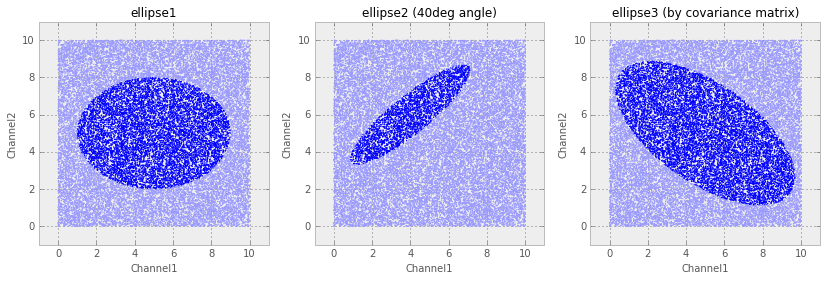

In [11]:
ellipse1 = EllipseGate(channels, [5, 5], [4, 3])
ellipse2 = EllipseGate(channels, [4, 6], [4, 1], degrees=40)
ellipse3 = EllipsoidGate(channels, [5, 5], [[22, -11], [-11, 15]])

print 'ellipse1 attributes:', ellipse1.center, ellipse1.axes, ellipse1.theta # theta in radians
print 'ellipse3 attributes:', ellipse3.center, ellipse3.cov
print 'ellipse1 covariance matrix', ellipse1.cov # EllipseGate inherits from EllipsoidGate

plt.subplot(131)
test_gate(ellipse1, 'ellipse1')

plt.subplot(132)
test_gate(ellipse2, 'ellipse2 (40deg angle)')

plt.subplot(133)
test_gate(ellipse3, 'ellipse3 (by covariance matrix)')

## Boolean Gates

`BooleanGate`s are composite gates created from multiple other gates. For each point, its membership in the boolean gate is a boolean function of its membership in the component gates. The boolean operators allowed are `AND`, `OR`, and `XOR`. `AND` creates the intersection of the member gate regions, `OR` is the union, and `XOR` does something weird but it's a built-in operator in Python so why not use it? (Technically, it allows events that are in an odd number of the component gates). Note that all three of these operators are commutatitve and associative so order of the component gates does not matter.

You may also use python's built-in bitwise operators `&`, `|`, and `^` directly on the gates themselves to yeild a boolean gate, as in `gate1 | gate2`.

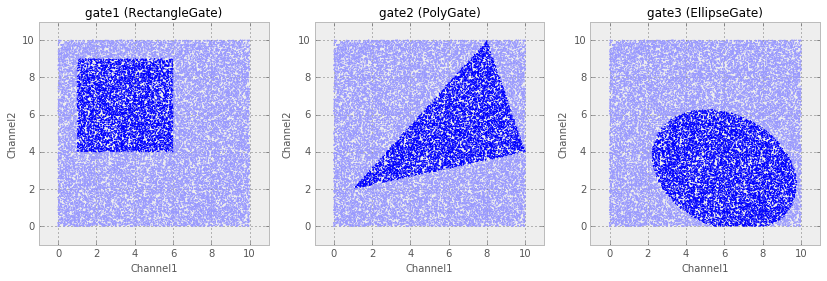

In [12]:
gate1 = RectangleGate(channels, [(1, 6), (4, 9)])
gate2 = PolyGate(channels, [(8, 10), (10, 4), (1, 2)])
gate3 = EllipseGate(channels, [6, 3], [4, 3], degrees=-30)

plt.subplot(131)
test_gate(gate1, 'gate1 (RectangleGate)')

plt.subplot(132)
test_gate(gate2, 'gate2 (PolyGate)')

plt.subplot(133)
test_gate(gate3, 'gate3 (EllipseGate)')

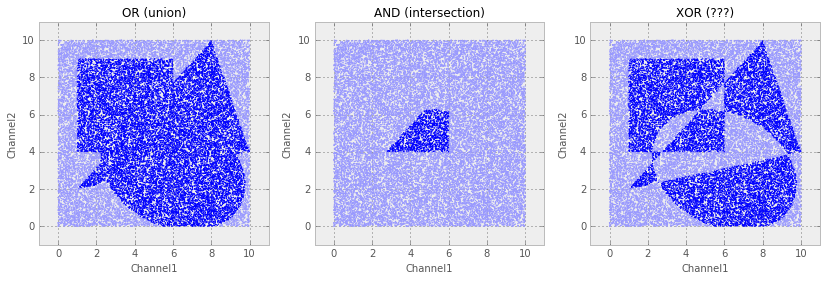

In [13]:
orgate = BooleanGate([gate1, gate2, gate3], 'or')
andgate = gate1 & gate2 & gate3 # using bitwise AND operator
xorgate = BooleanGate([gate1, gate2, gate3], 'xor')

plt.subplot(131)
test_gate(orgate, 'OR (union)')

plt.subplot(132)
test_gate(andgate, 'AND (intersection)')

plt.subplot(133)
test_gate(xorgate, 'XOR (???)')

## Inverted Gates

Gate instances may be wrapped in an `InvertedGate` instance to reject all points that were passed before and vice versa. This also happens when the bit-inversion unary operator (`~`) is used on a gate.

Below the three gates from the section above are inverted using both methods.

<class 'pycyt.gates.bases.InvertedGate'>
<class 'pycyt.gates.bases.InvertedGate'>
<class 'pycyt.gates.bases.InvertedGate'>


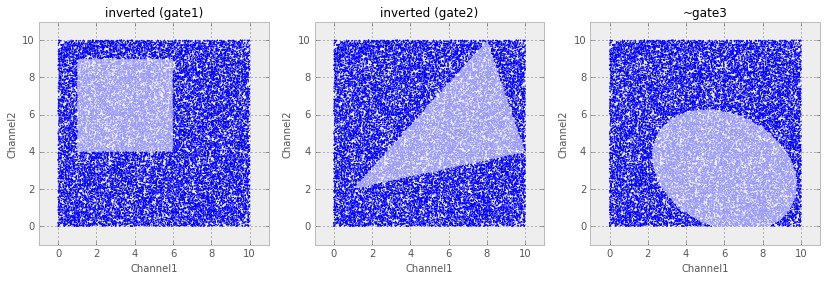

In [14]:
inv_gate1 = InvertedGate(gate1)
inv_gate2 = InvertedGate(gate2)
inv_gate3 = ~gate3

print type(inv_gate1)
print type(inv_gate2)
print type(inv_gate3)

plt.subplot(131)
test_gate(inv_gate1, 'inverted (gate1)')

plt.subplot(132)
test_gate(inv_gate2, 'inverted (gate2)')

plt.subplot(133)
test_gate(inv_gate3, '~gate3')

## Quad Gates (not yet implemented)

There is one more gate type commonly used in flow cytometry - the quad gate. This splits the data space into (typically) four regions, above or below the center point in each of the two dimensions on which it is defined. `pycyt` follows (will follow) the Gating-ML standard and allow more general quad gates in more dimensions (or less, the common "split gate" is an instance of this) and with more center/split points, dividing each channel/dimension into more than two regions.

Note that quad gates are not simple gates - they divide the data space into more regions than just an interior and an exterior. Moreover, no one of these regions is an obvious "default" so the region must always be given explicitly when gating.